In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import itertools
from collections import defaultdict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit, train_test_split, validation_curve,\
GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, \
roc_auc_score, roc_curve, auc, log_loss

In [6]:
df = pd.read_pickle('../pickle_files/cleaned_df.p')

In [7]:
df.columns

Index(['area_hectares', 'UNESCO', 'tareviews', 'ranking', 'rating', 'visitors',
       'Age'],
      dtype='object')

In [28]:
df.head()

,area_hectares,UNESCO,tareviews,ranking,rating,visitors,Age,log_area,log_reviews,log_visitors,Age_categories,agesBinned
Acadia National Park,12300.0,0.0,175.0,"(89, 9, 1, 1, 0)",5,3303393.0,101.0,9.417355,5.164786,15.010461,2.0,"(66.35, 105.0]"
American Samoa National Park,3600.0,0.0,46.0,"(58, 30, 10, 2, 0)",4.5,28892.0,29.0,8.188689,3.828641,10.271320,1.0,"(0.0, 66.35]"
Arches National Park,30900.0,0.0,1441.0,"(85, 11, 2, 1, 1)",5,1585718.0,88.0,10.338511,7.273093,14.276548,2.0,"(66.35, 105.0]"
Aulavik National Park,1220000.0,0.0,4.0,"(50, 50, 0, 0, 0)",4.5,8.0,25.0,14.014361,1.386294,2.079442,1.0,"(0.0, 66.35]"
Auyuittuq National Park,1970740.0,0.0,10.0,"(80, 10, 10, 0, 0)",4.5,400.0,16.0,14.493920,2.302585,5.991465,1.0,"(0.0, 66.35]"


In [8]:
df['log_area'] = df['area_hectares'].apply(np.log)
df['log_reviews'] = df['tareviews'].apply(np.log)
df['log_visitors'] = df['visitors'].apply(np.log)

In [10]:
df['UNESCO'].value_counts()

0.0    76
1.0    72
Name: UNESCO, dtype: int64

In [11]:
one = df['UNESCO'] == 1
zero = df['UNESCO'] == 0

#### Correcting one entry

In [14]:
df.loc['Hot Springs National Park', 'Age'] = 2017 -1921

#### Create weighted ranking scores

In [32]:
from ast import literal_eval

df['ranking'] = df['ranking'].apply(lambda x: literal_eval(x.replace('(', '').replace(')','')) )

In [33]:
df['ranking'] = df['ranking'].apply(lambda x: (x[0]*5 + x[1] * 4 + x[2] * 3 + x[3] * 2 + x[1] * 1) / 100) 

In [35]:
df['Weighted_ranking_score'] = df['ranking'] * np.log(df['tareviews'])

### Bin the data

In [23]:
def plot_histogram(df, feature, bins = 20):
    fig = plt.figure(figsize = (14, 8))
    ax1 = fig.add_subplot(111)
    ax1.hist(df[feature], bins = bins)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')
    ax1.set_title('Histogram of National Parks by {}'.format(feature), fontsize = 30);

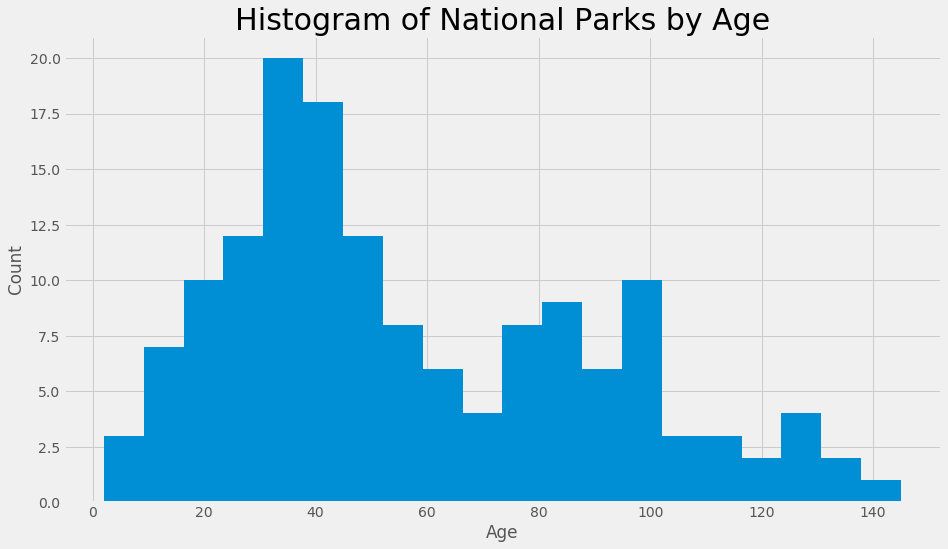

In [24]:
plot_histogram(df, 'Age', bins = 20)

In [21]:
bins = [0, 66.35, 105, 150]
group_names = [1., 2, 3]
categories = pd.cut(df['Age'], bins, labels = group_names)
df['Age_categories'] = pd.cut(df['Age'], bins, labels=group_names)
df['agesBinned'] = pd.cut(df['Age'], bins)

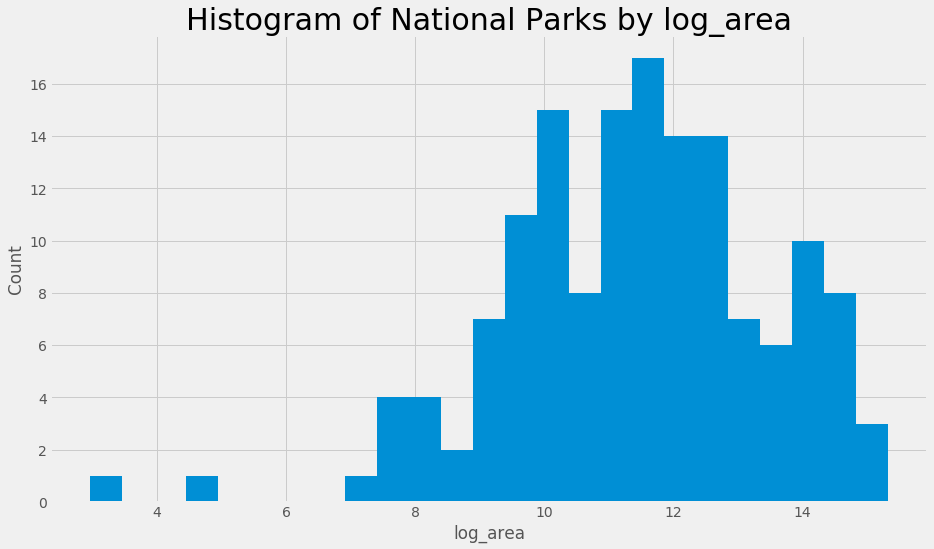

In [37]:
plot_histogram(df, 'log_area', bins = 25)

In [38]:
bins = [0, 6, 8.5 , 10.4, 13, 16]
group_names = [1., 2, 3, 4, 5]
categories = pd.cut(df['log_area'], bins, labels = group_names)
df['Size_categories'] = pd.cut(df['log_area'], bins, labels=group_names)
df['SizeBinned'] = pd.cut(df['log_area'], bins)

In [ ]:
plot_histogram(df, 'Weighted_ranking_score', bins = 25)

In [43]:
bins = [0, 9, 21 , 32, 41.5, 50]
group_names = [1., 2, 3, 4, 5]
categories = pd.cut(df['Weighted_ranking_score'], bins, labels = group_names)
df['Weighted_ranking_categories'] = pd.cut(df['Weighted_ranking_score'], bins, labels=group_names)
df['Weighted_rankingBinned'] = pd.cut(df['Weighted_ranking_score'], bins)

#### Final Features

In [54]:
cols = ['Age_categories', 'Size_categories', 'Weighted_ranking_categories']
X = df[cols].copy()
y = df['UNESCO'].copy()
Xy = X
Xy['UNESCO'] = y

In [57]:
X.drop('UNESCO', axis = 1, inplace = True)

#### Some places only have 1 review causing their weighted ranking to be NaN. I will assign them to category 1. 

In [72]:
mask = X[X['Weighted_ranking_categories'].isnull()==True].index.values
X.loc[mask, 'Weighted_ranking_categories'] = 1

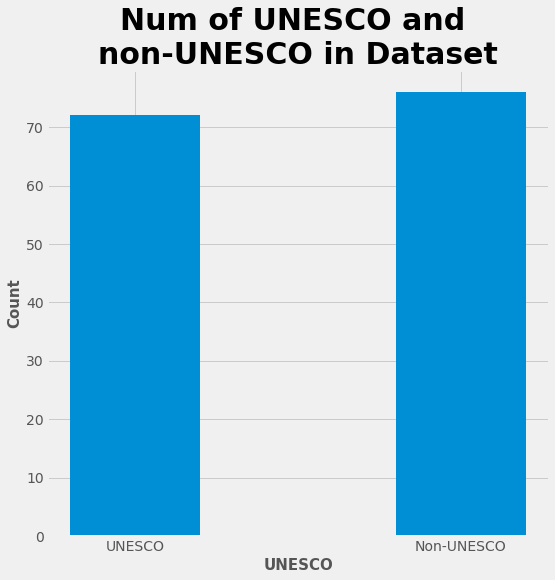

In [58]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('UNESCO', fontsize=15, weight='bold')
ax1.set_ylabel('Count', fontsize=15, weight='bold')
ax1.set_title('Num of UNESCO and \nnon-UNESCO in Dataset', fontsize=30, weight='bold')
y_pos = np.arange(len(y.value_counts()))
ax1.bar(y_pos, list(reversed(y.value_counts())), align = 'center', width = .4)
ax1.set_xticklabels(['UNESCO','Non-UNESCO'])
ax1.set_xticks(range(0,2));

In [59]:
models = [KNeighborsClassifier(n_neighbors = 5), 
          LogisticRegression(class_weight = 'balanced', random_state = 42),
          BernoulliNB(),
          SVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier()]

model_names = ['KNN', 
         'Logistic', 
         'Naive Bayes', 
         'SVM', 
         'Decision Tree', 
         'Random Forest']

In [60]:
def run_models_get_scores(X, y, models, model_names, test_size = 0.2, random_state = 42):
    '''
    input: X (df) or (series) of target features
    input: y (Series) of targets
    input: a list of models
    input: Verbose will output a dataframe summarizing the model
    output: a list of accuracy, precision, recall and f1 scores
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, 
                                                        stratify=y)
    sc = StandardScaler().fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    specificity = []


    for model in models:
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        
        # save confusion matrix and slice into four pieces
        confusion = confusion_matrix(y_test, y_pred)
 
        #[row, column]
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        specificity_score = TN / (TN + FP)

        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred,))
        specificity.append(specificity_score)

    df = pd.DataFrame({'Model' : model_names,
               'Accuracy' : accuracy, 
               'Precision' : precision,
               'Recall': recall,  
               'F1' : f1,
               'Specificity' : specificity        
                      })
    df.set_index('Model')
        
    return df

In [75]:
run_models_get_scores(X, y, models, model_names, test_size = 0.3, random_state = 42)

,Accuracy,F1,Model,Precision,Recall,Specificity
0,0.488889,0.439024,KNN,0.473684,0.409091,0.565217
1,0.622222,0.604651,Logistic,0.619048,0.590909,0.652174
2,0.600000,0.625000,Naive Bayes,0.576923,0.681818,0.521739
3,0.600000,0.625000,SVM,0.576923,0.681818,0.521739
4,0.555556,0.545455,Decision Tree,0.545455,0.545455,0.565217
5,0.511111,0.521739,Random Forest,0.500000,0.545455,0.478261


In [76]:
def cross_validate_scoring(X, y, models, model_names, cv = 3):
    '''
    performs cross validation to determine model performance
    input: X (df) or (Series) of targets
    input: y (Series) of targets
    models: (list) of models
    model_names: (list) of model names
    cv: (int) number of cross validation folds
    output: (df) with results of the models
    '''    
    
    scores = ('accuracy', 'f1', 'precision', 'recall', 'roc_auc')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, 
                                                    stratify=y)
    
    sc = StandardScaler().fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    df = pd.DataFrame()
    
    for score in scores:    
        score_lst = []
        for model in models:
            score_lst.append(np.mean(cross_val_score(model, X_train_std, y_train, scoring = score, cv = cv, 
                                                     n_jobs = -1)))
        df[score] = score_lst
    
    df['Models'] = model_names
    df = df.set_index('Models')
    return df

In [77]:
models = [KNeighborsClassifier(n_neighbors = 5), 
          LogisticRegression(class_weight = 'balanced', random_state = 42),
          BernoulliNB(), 
          SVC(kernel = 'rbf'),
          DecisionTreeClassifier(),
          RandomForestClassifier()]

model_names = ['KNN', 
         'Logistic', 
         'Naive Bayes',
         'SVM', 
         'Decision Tree', 
         'Random Forest']

In [78]:
results = cross_validate_scoring(X, y, models, model_names, cv = 4)
results

,accuracy,f1,precision,recall,roc_auc
Models,,,,,
KNN,0.562379,0.444549,0.590278,0.360577,0.616309
Logistic,0.562792,0.543409,0.538619,0.560897,0.601543
Naive Bayes,0.505014,0.482373,0.497222,0.480769,0.555870
SVM,0.611638,0.612590,0.601763,0.639423,0.669590
Decision Tree,0.573120,0.523833,0.568403,0.503205,0.627976
Random Forest,0.582379,0.569542,0.587500,0.583333,0.671827


In [82]:
results_sorted = results.sort_values('f1')

#### Baseline model where 1 is always predicted

In [83]:
baseline = pd.Series([0.4864864864864865], index=['Baseline'])
combined = results_sorted['f1'].append(baseline)
combined.sort_values()

KNN              0.444549
Naive Bayes      0.482373
Baseline         0.486486
Decision Tree    0.523833
Logistic         0.543409
Random Forest    0.569542
SVM              0.612590
dtype: float64

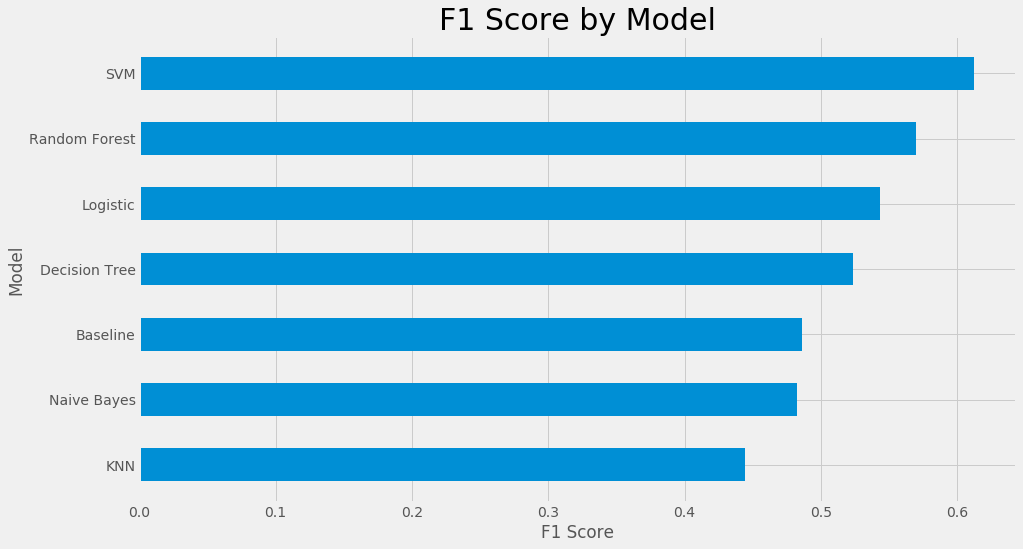

In [84]:
ind = np.arange(len(combined))
width = 0.5

labels = combined.sort_values().index
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.set_title('F1 Score by Model', fontsize = 30)
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Model')
ax1.barh(ind, combined.sort_values(), width)
ax1.set_yticks(ind)
ax1.set_yticklabels(labels);

### Test SVM Kernels

In [91]:
def run_SVM(X, y, models, model_names, test_size = 0.3, random_state = 42):
    '''
    input: X (df) or (series) of target f|eatures
    input: y (Series) of targets
    input: a list of models
    input: Verbose will output a dataframe summarizing the model
    output: a list of accuracy, precision, recall and f1 scores
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, 
                                                        stratify=y)

    sc = StandardScaler().fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    specificity = []
    log_loss_lst = []


    for model in models:
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        # save confusion matrix and slice into four pieces
        confusion = confusion_matrix(y_test, y_pred)
 
        #[row, column]
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        specificity_score = TN / (TN + FP)
        

        accuracy.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        log_loss_lst.append(log_loss(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))        
        specificity.append(specificity_score)
        

    
    df = pd.DataFrame({'Model' : model_names,
               'Accuracy' : accuracy, 
               'F1' : f1,
               'Log Loss': log_loss_lst,
               'Precision' : precision,
               'Recall': recall,  
               'Specificity' : specificity                
                      })
    df.set_index('Model')
    
    df = df.set_index('Model')
    return df

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, 
                                                        stratify=y)
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [95]:
kernels = [SVC(kernel='rbf', random_state = 42, class_weight = 'balanced'), 
           SVC(kernel='poly', random_state = 42, class_weight = 'balanced'), 
           LinearSVC(random_state = 42, class_weight = 'balanced')]
kernel_names = ['rbf', 'poly', 'linear']

In [96]:
kernals = run_SVM(X, y, kernels, kernel_names, test_size = 0.3, random_state = 42)
sorted_kernals = kernals.sort_values('F1')
sorted_kernals

,Accuracy,F1,Log Loss,Precision,Recall,Specificity
Model,,,,,,
linear,0.622222,0.604651,13.048124,0.619048,0.590909,0.652174
rbf,0.600000,0.625000,13.815706,0.576923,0.681818,0.521739
poly,0.577778,0.654545,14.583305,0.545455,0.818182,0.347826


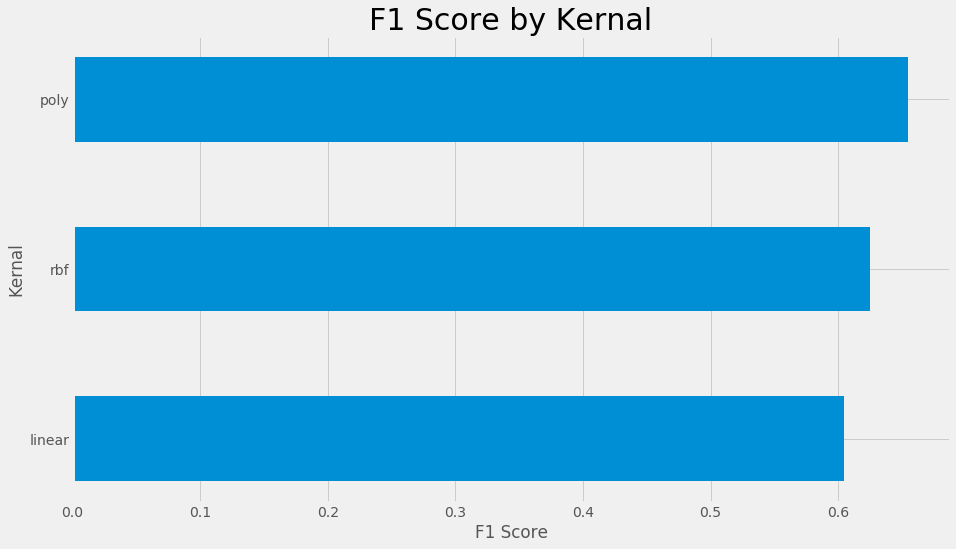

In [97]:
ind = np.arange(len(sorted_kernals))
width = 0.5

labels = sorted_kernals.index.values
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.set_title('F1 Score by Kernal', fontsize = 30)
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Kernal')
ax1.barh(ind, sorted_kernals['F1'], width)
ax1.set_yticks(ind)
ax1.set_yticklabels(labels);

#### Go with the poly kernel

In [98]:
svm = SVC(kernel='poly', random_state = 42, probability = True, class_weight = 'balanced')
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

#### Out of sample confusion matrix

Confusion matrix, without normalization
[[ 8 15]
 [ 4 18]]


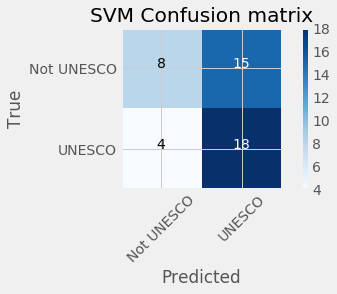

In [100]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Not UNESCO', 'UNESCO'],
                      title='SVM Confusion matrix')

#### In sample confusion matrix

Confusion matrix, without normalization
[[18 35]
 [ 4 46]]


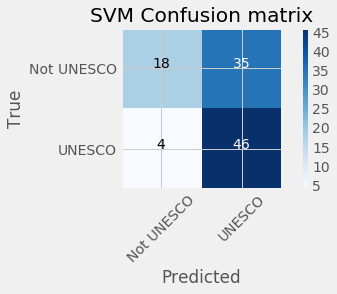

In [104]:
y_train_pred = svm.predict(X_train_std)
cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Not UNESCO', 'UNESCO'],
                      title='SVM Confusion matrix')

In [105]:
def get_scores(X, y, model):
    '''
    get training and testing summary statistics for a model
    input: X (pandas df) of features
    input: y (pandas Series) of targets
    input: model_name (str) of model name
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    model = model
    model.fit(X_train_std, y_train)
    y_train_pred = svm.predict(X_train_std)
    y_pred = svm.predict(X_test_std)
    
    cm = confusion_matrix(y_train, y_train_pred)
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    train_accuracy = (TP + TN) / (TP + TN + FP + FN)
    train_sensitivity = TP / (FN + TP)
    train_specificity = TN / (TN + FP)
    train_precision = TP / (FP + TP)
    train_f1 = 2 * ((train_precision * train_sensitivity) / (train_precision + train_sensitivity))

    
    cm = confusion_matrix(y_test, y_pred)
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    test_accuracy = (TP + TN) / (TP + TN + FP + FN)
    test_sensitivity = TP / (FN + TP)
    test_specificity = TN / (TN + FP)
    test_precision = TP / (FP + TP)
    test_f1 = 2 * ((test_precision * test_sensitivity) / (test_precision + test_sensitivity))

    df = pd.DataFrame({'Train/Test': ['Train', 'Test'], 
                               'Accuracy': [train_accuracy, test_accuracy],
                               'F1': [train_f1, test_f1], 
                               'Precision': [train_precision, test_precision], 
                               'Sensitivity': [train_sensitivity, test_sensitivity],
                               'Specificity': [train_specificity, test_specificity]
                                }) 
    
    df = df.set_index('Train/Test')
    return df

In [106]:
scores_df = get_scores(X, y, svm)
scores_df

,Accuracy,F1,Precision,Sensitivity,Specificity
Train/Test,,,,,
Train,0.621359,0.702290,0.567901,0.920000,0.339623
Test,0.577778,0.654545,0.545455,0.818182,0.347826


In [110]:
def plot_learning_curve(estimator, title, scoring, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.2, 1.0, 5)):
    '''
    estimator: (object) a trained and fit model object
    title: (str) of graph title
    scoring: (str) of desired scoring metric, must be from sklearn.metrics
    X: (pandas df of features)
    y: (pandas Series of target)
    cv: (int) number of folds for cross validation
    
    '''

    fig = plt.figure(figsize = (14,8))
    ax1 = fig.add_subplot(111)
    ax1.set_title(title, fontsize = 30)
    ax1.set_xlabel("Number of Observations")
    ax1.set_ylabel("F1 Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)

    test_scores_mean = np.mean(test_scores, axis=1)
    
    ax1.plot(train_sizes, train_scores_mean, label="Training score", linewidth = 5)
    
    ax1.plot(train_sizes, test_scores_mean, label="Cross validation score", linewidth = 5)

    ax1.legend();

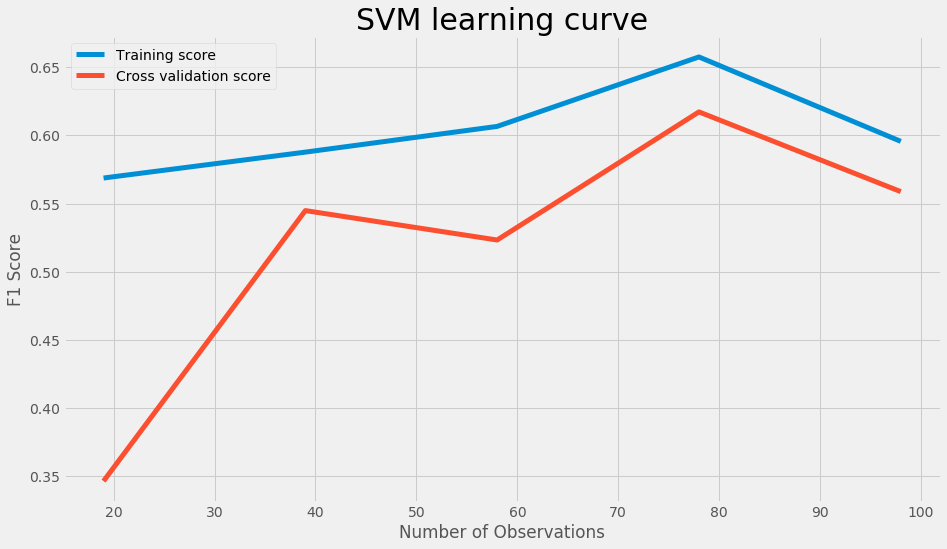

In [111]:
plot_learning_curve(estimator = svm, cv = 3, title = 'SVM learning curve', scoring = 'f1', X = X, y = y);

### Tune the model

In [112]:
cs=[0.0001, 0.001, 0.1, 1.0, 10, 100, 1000]
gammas = [0, 0.1, 0.001, 0.0001, 0.00001]

In [113]:
# create a parameter grid: map the parameter names to the values that should be serached
param_grid = dict(C = cs, gamma = gammas)
param_dist = dict(C = cs, gamma = gammas)

In [114]:
def do_grid_search(X, y, model, param_grid, cv, scoring):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, 
                                                stratify=y)

    sc = StandardScaler().fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    d = defaultdict(list)
    scores_lst = []
    for i in cv:
        grid = GridSearchCV(model, param_grid, cv = i, scoring = scoring, n_jobs = -1)
        grid.fit(X_train_std, y_train)
        d[i].append(grid.best_score_)
        d[i].append(grid.best_params_)
    df = pd.DataFrame(d).T
    df.columns = [scoring, 'params']
    df.index.name = 'Num of CV folds'
    return df

In [116]:
import warnings
warnings.filterwarnings('ignore')
grid_search_df = do_grid_search(X, y, svm, param_grid, cv = range(2,8), scoring = 'f1')
grid_search_df

,f1,params
Num of CV folds,,
2,0.653581,"{'C': 0.0001, 'gamma': 0}"
3,0.654123,"{'C': 100, 'gamma': 0.1}"
4,0.653551,"{'C': 0.1, 'gamma': 0}"
5,0.640331,"{'C': 100, 'gamma': 0.1}"
6,0.653463,"{'C': 0.001, 'gamma': 0}"
7,0.653427,"{'C': 0.0001, 'gamma': 0}"


#### Final Model

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, 
                                                        stratify=y)
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [118]:
svm = SVC(kernel='poly', random_state = 42, probability = True, class_weight = 'balanced', C = 100, gamma = 0.1)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
y_train_pred = svm.predict(X_train_std)

In [119]:
scores_df = get_scores(X, y, svm)
scores_df

,Accuracy,F1,Precision,Sensitivity,Specificity
Train/Test,,,,,
Train,0.621359,0.702290,0.567901,0.920000,0.339623
Test,0.577778,0.654545,0.545455,0.818182,0.347826


#### Out of sample confusion matrix

Confusion matrix, without normalization
[[ 8 15]
 [ 4 18]]


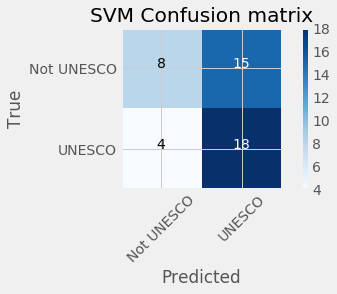

In [120]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Not UNESCO', 'UNESCO'],
                      title='SVM Confusion matrix')

#### In sample confusion matrix

Confusion matrix, without normalization
[[18 35]
 [ 4 46]]


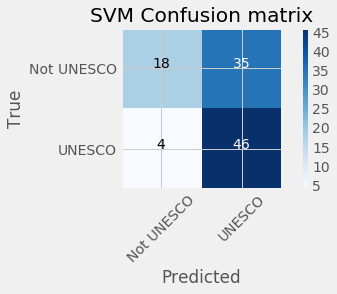

In [121]:
y_train_pred = svm.predict(X_train_std)
cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Not UNESCO', 'UNESCO'],
                      title='SVM Confusion matrix')

In [122]:
y_pred_proba = svm.predict_proba(X_test_std)
y_pred_proba = y_pred_proba.tolist()
y_pred_proba = [x[1] for x in y_pred_proba]
y_train_pred_proba = svm.predict_proba(X_train_std)
y_train_pred_proba = y_train_pred_proba.tolist()
y_train_pred_proba = [x[1] for x in y_train_pred_proba]

auc = roc_auc_score(y_test, y_pred_proba)

In [123]:
def plot_roc_curve(y_test, y_pred_proba, model_name, auc):
    '''
    input: y_test (pd.series)
    input: y_pred_proba (array of probabilities)
    input: title (str)
    input: auc (float) of auc score
    '''
    fpr, tpr, threshholds = roc_curve(y_test, y_pred_proba)
    fig = plt.figure(1, figsize= (14,8))
    ax1 = fig.add_subplot(111)
    ax1.plot(fpr, tpr, linewidth = 3, label = '{0} ROC\nAUC = {1:.3f}'.format(model_name, auc))
    ax1.plot([0, 1], [0, 1], linestyle = '--', color = 'black')
    ax1.set_title('ROC Curve ({0} Model)'.format(model_name), fontsize = 30, weight = 'bold')
    ax1.set_xlabel('False Positive Rate (1 - Specificity)', fontsize = 15, weight = 'bold')
    ax1.set_ylabel('TPR (Sensitivity)', fontsize = 15, weight = 'bold')
    ax1.legend(prop={'size': 25});

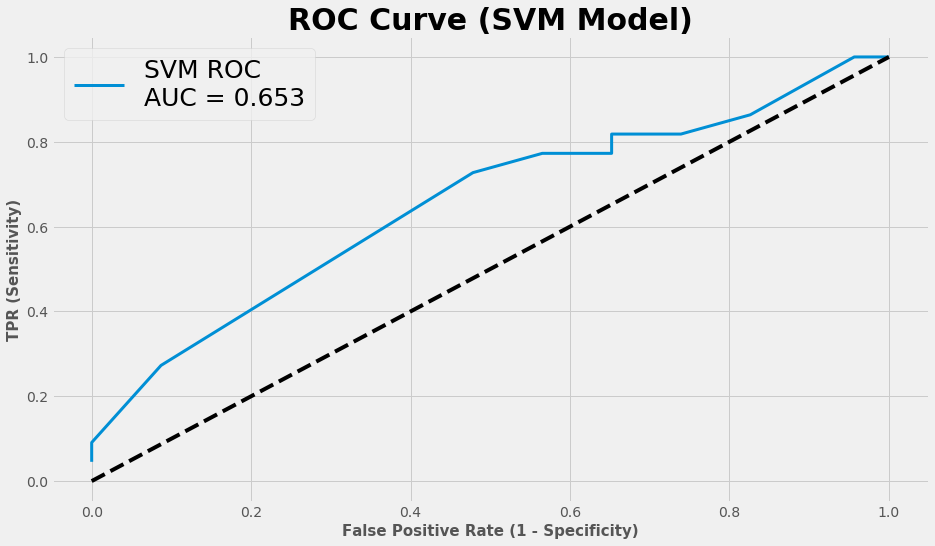

In [124]:
plot_roc_curve(y_test, y_pred_proba, 'SVM', auc = auc)

In [125]:
d = {'Prediction': y_pred, 
     'Actual': y_test.values, 
     'Site': y_test.index.values, 
     'Prediction Probability': y_pred_proba}
results_df = pd.DataFrame(d)
results_df = results_df.set_index('Site')

In [128]:
d1 = {'Prediction': y_train_pred, 'Actual': y_train.values, 'Site': y_train.index.values, 
     'Prediction Probability': y_train_pred_proba}
results_df1 = pd.DataFrame(d1)
results_df1 = results_df1.set_index('Site')

In [131]:
results_all = pd.concat([results_df, results_df1])